### Super-Resolution Convolutional Neural Network 

In [297]:
#Load library
import os
import cv2
import h5py
import math
import numpy
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import warnings
warnings.filterwarnings("ignore")

### Feature and Label Construction

In [299]:
#Set train data directories
train_LR_dir = "../data/train_set/LR/"
train_HR_dir = "../data/train_set/HR/"
LR_dir_name = os.listdir(train_LR_dir)
HR_dir_name = os.listdir(train_HR_dir)
n_files = len(LR_dir_name)
#initial values
Random_Crop =30 #number of sample patches
Patch_size = 32 
label_size = 20
conv_side = 6 
learn_rate = 0.0003

In [300]:
feature_start_time = time.time()
#Set feature and label dimension
train_data = numpy.zeros((n_files * Random_Crop,  Patch_size, Patch_size,1), dtype=numpy.double) #feature size 32 * 32 * 1
train_label = numpy.zeros((n_files * Random_Crop,  label_size, label_size,1), dtype=numpy.double) #label size 20 * 20 * 1

for i in range(n_files):
    
    LR_file_path = train_LR_dir + LR_dir_name[i] #Low Resolution image path
    HR_file_path = train_HR_dir + HR_dir_name[i] #High Resolution image path
    
    hr_img = cv2.imread(HR_file_path,cv2.IMREAD_COLOR) #Read High Resolution image as label
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb) #Convert RGB to YCrCb Color type
    hr_img = hr_img[:, :, 0] #Use Y color channel for trainning
    shape = hr_img.shape #High Resolution shape
    
    lr_img = cv2.imread(LR_file_path,cv2.IMREAD_COLOR)# Read low Resolution image as feature
    lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2YCrCb)#Convert RGB to YCrCb Color type
    lr_img = lr_img[:, :, 0]#Use Y color channel for trainning
    lr_img = cv2.resize(lr_img,(shape[1],shape[0]),interpolation = cv2.INTER_CUBIC) #Resize the LR to HR size using cubic interpolation
    
    #Select random points
    numpy.random.seed(2019)
    Points_x = numpy.random.randint(0, shape[0]- Patch_size, Random_Crop)
    Points_y = numpy.random.randint(0, shape[1]- Patch_size, Random_Crop)   
    
    #Construct patches by random points
    for j in range(Random_Crop):
        lr_patch = lr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]
        hr_patch = hr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]
   
    #Convert pixel range from (0,255) to (0,1)
        lr_patch = lr_patch.astype(float) / 255.
        hr_patch = hr_patch.astype(float) / 255.
    
    #Construct feature and label matrix
        train_data[i * Random_Crop + j,  :, :,0] = lr_patch
        train_label[i * Random_Crop + j, :, :,0] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]
        
feature_end_time = time.time()
feature_time = feature_end_time - feature_start_time

In [301]:
train_data.shape

(45000, 32, 32, 1)

In [302]:
train_label.shape

(45000, 20, 20, 1)

In [303]:
#write h5 file for feature and label construction
def write_h5py(x,y):
    x = train_data.astype(numpy.float32)
    y = train_label.astype(numpy.float32)
    with h5py.File("../lib/train.h5", 'w') as h:
        h.create_dataset('train_data', data=x, shape=x.shape)
        h.create_dataset('train_label', data=y, shape=y.shape)

In [304]:
#Save train feature h5py file
#write_h5py(train_data,train_label)

### Train Images

In [48]:
# reading saved h5py train feature file
def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = numpy.array(hf.get('train_data'))
        label = numpy.array(hf.get('train_label'))
        return data, label

In [307]:
#train_data,train_label =  read_training_data("../lib/train.h5") 

In [305]:
#Build trainning model
def train_model():
    SRCNN = tf.keras.Sequential()
    SRCNN.add(tf.keras.layers.Conv2D(64, kernel_size=9,activation='relu', padding='valid',input_shape=(Patch_size, Patch_size, 1)))#patch size
    SRCNN.add(tf.keras.layers.Conv2D(32, kernel_size=1,activation='relu', padding='valid'))
    SRCNN.add(tf.keras.layers.Conv2D(1, kernel_size=5,activation='linear', padding='valid'))
    adam = tf.keras.optimizers.Adam(lr=learn_rate)
    SRCNN.compile(optimizer=adam, loss='mse')
    return SRCNN

In [306]:
SRCNN_train = train_model()
print(SRCNN_train.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 24, 24, 64)        5248      
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 24, 24, 32)        2080      
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 20, 20, 1)         801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________
None


In [276]:
#training
train_start_time = time.time()
training = SRCNN_train.fit(train_data,train_label,batch_size=128,epochs=100)
train_end_time = time.time()
train_time = train_end_time - train_start_time

Epoch 1/100
45000/45000 [==============================] - 3s 62us/step - loss: 0.0089
Epoch 2/100
45000/45000 [==============================] - 2s 51us/step - loss: 0.0026
Epoch 3/100
45000/45000 [==============================] - 2s 51us/step - loss: 0.0026
Epoch 4/100
45000/45000 [==============================] - 2s 51us/step - loss: 0.0025
Epoch 5/100
45000/45000 [==============================] - 2s 51us/step - loss: 0.0025
Epoch 6/100
45000/45000 [==============================] - 2s 49us/step - loss: 0.0025
Epoch 7/100
45000/45000 [==============================] - 2s 50us/step - loss: 0.0025
Epoch 8/100
45000/45000 [==============================] - 2s 50us/step - loss: 0.0025
Epoch 9/100
45000/45000 [==============================] - 2s 50us/step - loss: 0.0025
Epoch 10/100
45000/45000 [==============================] - 2s 51us/step - loss: 0.0025
Epoch 11/100
45000/45000 [==============================] - 2s 52us/step - loss: 0.0025
Epoch 12/100
45000/45000 [===============

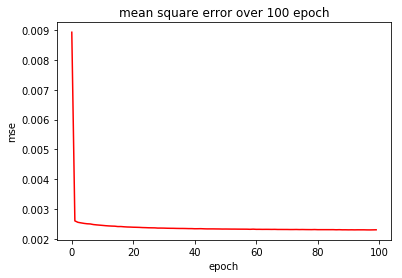

In [308]:
plt.plot(training.history['loss'],color = 'red')
plt.title('mean square error over 100 epoch')
plt.xlabel('epoch')
plt.ylabel('mse')
plt.show()

In [278]:
train_mse = training.history['loss'][-1]
train_psnr = round(20 * math.log10(1.) - 10 * math.log10(train_mse),2)
print('Training data mse: {}   psnr : {} '.format(train_mse,train_psnr))

Training data mse: 0.0023110840724160273   psnr : 26.36 


In [279]:
#Save training model weights
SRCNN_train.save_weights("../lib/my_weight.h5")

### Predict Images

In [280]:
#Buiding predict model
def predict_model():
    SRCNN = tf.keras.Sequential()
    SRCNN.add(tf.keras.layers.Conv2D(64, kernel_size=9,activation='relu', padding='valid',input_shape=(None, None, 1)))
    SRCNN.add(tf.keras.layers.Conv2D(32, kernel_size=1,activation='relu', padding='valid'))
    SRCNN.add(tf.keras.layers.Conv2D(1, kernel_size=5,activation='linear', padding='valid'))
    adam = tf.keras.optimizers.Adam(lr=learn_rate)
    SRCNN.compile(optimizer=adam, loss='mse', metrics=['mse'])
    return SRCNN

In [281]:
#Load model and weights
SRCNN_pred = predict_model()
SRCNN_pred.load_weights("../lib/my_weight.h5")
#Set test data directories
test_lr_dir = "../data/test_set/LR/"
test_super_dir = "../data/test_set/SR-I/"
test_hr_dir = "../data/test_set/HR/"
test_lr_name = os.listdir(test_lr_dir)
n_test_files = len(test_lr_name)

In [282]:
#predict SR
predict_start_time= time.time()

for i in range(n_test_files):
    test_lr_img_path= test_lr_dir + test_lr_name[i]
    test_lr_img = cv2.imread(test_lr_img_path,cv2.IMREAD_COLOR) 
    test_lr_img = cv2.cvtColor(test_lr_img,cv2.COLOR_BGR2YCrCb) #convert to YCrCb color type  
    t_shape = test_lr_img.shape
    
    #double the size of LR by cubic interpolation
    test_lr_img = cv2.resize(test_lr_img,(t_shape[1]*2,t_shape[0]*2),interpolation = cv2.INTER_CUBIC)
    new_shape = test_lr_img.shape

    #Construct feature dimension for CNN (1*height*width*1)
    Y_img = test_lr_img[:,:,0]     
    Y = numpy.zeros((1, new_shape[0], new_shape[1], 1), dtype=float)
    Y[0, :, :, 0] = Y_img.astype(float) / 255.     
    
    #predict super resolution images
    pre = SRCNN_pred.predict(Y, batch_size=1) * 255.  
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0 
    pre = pre.astype(numpy.uint8)# integer (0 to 255) type
    
    #Construct full super resolution images
    test_lr_img[6: -6, 6: -6, 0] = pre[0, :, :, 0] 
    test_lr_img = cv2.cvtColor(test_lr_img,cv2.COLOR_YCrCb2BGR) #convert color back to BGR type
    
    #Write SR images
    cv2.imwrite(os.path.join(test_super_dir, test_lr_name[i]), test_lr_img)
    
predict_end_time = time.time()
predict_time = predict_end_time - predict_start_time 

### Summarize Running Time

In [ ]:
print('Feature and label construction time : {} sec \n\nTraining time : {} sec\n\nPredicting and writing SR images time : {} sec'.format(feature_time,train_time,predict_time))

In [284]:
#get test image PSNR 
def get_psnr(HR,SR):
    HR = numpy.array(HR,dtype = float)
    SR = numpy.array(SR,dtype = float)
    DIFF = SR - HR
    DIFF = DIFF.flatten('C')    
    MSE =numpy.mean(DIFF ** 2.)
    PSNR = 20 * math.log10(255.) - 10 * math.log10(MSE)
    return PSNR

In [ ]:
PSNR = []
for i in range(n_test_files):
    SR = cv2.imread(os.path.join(test_super_dir,test_lr_name[i]))
    HR = cv2.imread(os.path.join(test_hr_dir,test_lr_name[i]))
    PSNR.append(get_psnr(HR,SR))

In [ ]:
PSNR

In [ ]:
print('Testing data average psnr: {} '.format(numpy.mean(PSNR)))

### References
https://github.com/MarkPrecursor/SRCNN-keras

https://github.com/tegg89/SRCNN-Tensorflow

Dong, C., Loy, C. C., He, K., & Tang, X. (2016). Image super-resolution using deep convolutional networks. IEEE transactions on pattern analysis and machine intelligence, 38(2), 295-307.https://arxiv.org/pdf/1501.00092.pdf